In [1]:
import sys
import os
from pathlib import Path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from data.data_loader import DataLoader
import data.indicators as Indicators
import numpy as np
import pandas as pd

parent_dir = Path().resolve().parent
models_dir = parent_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True)

dfmain = DataLoader.load_data()
df = dfmain.copy()
len(df)
# Convert 'datetime' column to proper datetime format
df["datetime"] = pd.to_datetime(df["datetime"])

# Create 'seconds' column (Unix timestamp)
df["seconds"] = df["datetime"].map(pd.Timestamp.timestamp)

print(df)

      Unnamed: 0            datetime      open      high       low     close  \
0              0 2019-09-08 12:00:00  10000.00  10000.00  10000.00  10000.00   
1              1 2019-09-08 18:00:00  10344.77  10412.65  10324.77  10391.63   
2              2 2019-09-09 00:00:00  10316.62  10316.68  10251.51  10304.32   
3              3 2019-09-09 06:00:00  10304.32  10475.54  10077.22  10414.60   
4              4 2019-09-09 12:00:00  10411.70  10411.70  10183.31  10263.33   
...          ...                 ...       ...       ...       ...       ...   
6298        6298 2023-12-31 00:00:00  42174.30  42478.90  42001.00  42235.20   
6299        6299 2023-12-31 06:00:00  42235.30  42951.00  42225.50  42561.80   
6300        6300 2023-12-31 12:00:00  42561.80  42741.60  42381.00  42651.90   
6301        6301 2023-12-31 18:00:00  42651.90  42766.70  42083.10  42314.00   
6302        6302 2024-01-01 00:00:00  42314.00  42832.00  42207.90  42272.60   

         volume        date       secon

In [2]:
def generate_perfect_signals(df, lookahead):
    df = df.copy()
    df['signals'] = np.nan  # Initialize with NaN for proper trend marking

    for i in range(len(df) - lookahead):
        future_prices = df['close'].iloc[i+1 : i+1+lookahead].values
        if len(future_prices) > 0:
            max_future_price = np.max(future_prices)
            min_future_price = np.min(future_prices)

            # If the price is near the lowest future price, mark an uptrend (1)
            if df['close'].iloc[i] <= min_future_price + 0.1:
                df.at[i, 'signals'] = 1  # Uptrend

            # If the price is near the highest future price, mark a downtrend (0)
            elif df['close'].iloc[i] >= max_future_price - 0.1:
                df.at[i, 'signals'] = 0  # Downtrend

    # **Propagate the trend signals forward**
    df['signals'] = df['signals'].ffill().fillna(0)  # Fill NaN values with previous trend, default to 0
    
    return df

df = generate_perfect_signals(dfmain,20)
print(df['signals'])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6298    0.0
6299    0.0
6300    0.0
6301    0.0
6302    0.0
Name: signals, Length: 6303, dtype: float64


## Data Processing

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
features = [
        "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
        "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
        "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", "seconds"
    ]
df_as_np = df[features].to_numpy()

def preprocess_data(df, window_size):
    df.dropna(inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    df[features] = scaler.fit_transform(df[features])

    # Convert into time-series sequences (shape: [samples, timesteps, features])
    X, y = [], []
    df_as_np = df[features].to_numpy()
    for i in range(len(df_as_np) - window_size):
        row = df_as_np[i:i+window_size]  # This keeps shape (60, 46)
        X.append(row)
        y.append(df_as_np[i+window_size])  # Target at t+window_size

    return np.array(X), np.array(y), df, scaler  # Return scaler for inverse transform

# Preprocess the data
X, y, processed_df, scaler = preprocess_data(df, window_size=60)
print(X.shape) 
print(y.shape)
# Save the processed dataframe to a CSV file
processed_df.to_csv("processed_data.csv", index=False)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


(6144, 60, 18)
(6144, 18)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"🔥 Using device: {device}")

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=17, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # Take only the last timestep output
        return x

# Instantiate model
input_size = X_train.shape[2]  # Number of features
output_size = y_train.shape[1]  # Number of target variables
lstm_model = LSTMModel(input_size, output_size=output_size).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with progress bar
epochs = 20
for epoch in range(epochs):
    lstm_model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(lstm_model.state_dict(), "LSTM_FNN_LSTM_model.pth")
print("✅ Model saved as 'LSTM_FNN_LSTM_model.pth'")


🔥 Using device: cuda


Epoch 1/20: 100%|██████████| 154/154 [00:01<00:00, 153.22batch/s, loss=0.0246]


✅ Epoch [1/20], Loss: 0.0476, Val Loss: 0.0150


Epoch 2/20: 100%|██████████| 154/154 [00:00<00:00, 196.42batch/s, loss=0.0152]


✅ Epoch [2/20], Loss: 0.0136, Val Loss: 0.0101


Epoch 3/20: 100%|██████████| 154/154 [00:00<00:00, 180.96batch/s, loss=0.0077]


✅ Epoch [3/20], Loss: 0.0099, Val Loss: 0.0066


Epoch 4/20: 100%|██████████| 154/154 [00:00<00:00, 192.16batch/s, loss=0.0059]


✅ Epoch [4/20], Loss: 0.0081, Val Loss: 0.0049


Epoch 5/20: 100%|██████████| 154/154 [00:00<00:00, 185.37batch/s, loss=0.0048]


✅ Epoch [5/20], Loss: 0.0072, Val Loss: 0.0038


Epoch 6/20: 100%|██████████| 154/154 [00:00<00:00, 184.75batch/s, loss=0.0062]


✅ Epoch [6/20], Loss: 0.0066, Val Loss: 0.0047


Epoch 7/20: 100%|██████████| 154/154 [00:00<00:00, 196.43batch/s, loss=0.0055]


✅ Epoch [7/20], Loss: 0.0061, Val Loss: 0.0035


Epoch 8/20: 100%|██████████| 154/154 [00:00<00:00, 187.55batch/s, loss=0.0044]


✅ Epoch [8/20], Loss: 0.0058, Val Loss: 0.0033


Epoch 9/20: 100%|██████████| 154/154 [00:00<00:00, 188.78batch/s, loss=0.0067]


✅ Epoch [9/20], Loss: 0.0053, Val Loss: 0.0029


Epoch 10/20: 100%|██████████| 154/154 [00:00<00:00, 188.41batch/s, loss=0.0049]


✅ Epoch [10/20], Loss: 0.0050, Val Loss: 0.0034


Epoch 11/20: 100%|██████████| 154/154 [00:00<00:00, 196.08batch/s, loss=0.0048]


✅ Epoch [11/20], Loss: 0.0047, Val Loss: 0.0031


Epoch 12/20: 100%|██████████| 154/154 [00:00<00:00, 177.45batch/s, loss=0.0038]


✅ Epoch [12/20], Loss: 0.0046, Val Loss: 0.0032


Epoch 13/20: 100%|██████████| 154/154 [00:00<00:00, 168.56batch/s, loss=0.0041]


✅ Epoch [13/20], Loss: 0.0044, Val Loss: 0.0037


Epoch 14/20: 100%|██████████| 154/154 [00:00<00:00, 181.23batch/s, loss=0.0028]


✅ Epoch [14/20], Loss: 0.0041, Val Loss: 0.0025


Epoch 15/20: 100%|██████████| 154/154 [00:00<00:00, 188.73batch/s, loss=0.0029]


✅ Epoch [15/20], Loss: 0.0040, Val Loss: 0.0026


Epoch 16/20: 100%|██████████| 154/154 [00:00<00:00, 189.14batch/s, loss=0.0039]


✅ Epoch [16/20], Loss: 0.0037, Val Loss: 0.0032


Epoch 17/20: 100%|██████████| 154/154 [00:00<00:00, 180.90batch/s, loss=0.0030]


✅ Epoch [17/20], Loss: 0.0036, Val Loss: 0.0025


Epoch 18/20: 100%|██████████| 154/154 [00:00<00:00, 177.34batch/s, loss=0.0028]


✅ Epoch [18/20], Loss: 0.0034, Val Loss: 0.0021


Epoch 19/20: 100%|██████████| 154/154 [00:00<00:00, 177.09batch/s, loss=0.0031]


✅ Epoch [19/20], Loss: 0.0033, Val Loss: 0.0024


Epoch 20/20: 100%|██████████| 154/154 [00:00<00:00, 182.37batch/s, loss=0.0030]


✅ Epoch [20/20], Loss: 0.0031, Val Loss: 0.0019
✅ Model saved as 'LSTM_FNN_LSTM_model.pth'


🔹 Test MSE: 0.001902
🔹 Test MAE: 0.032278
🔹 R² Score: 0.6575


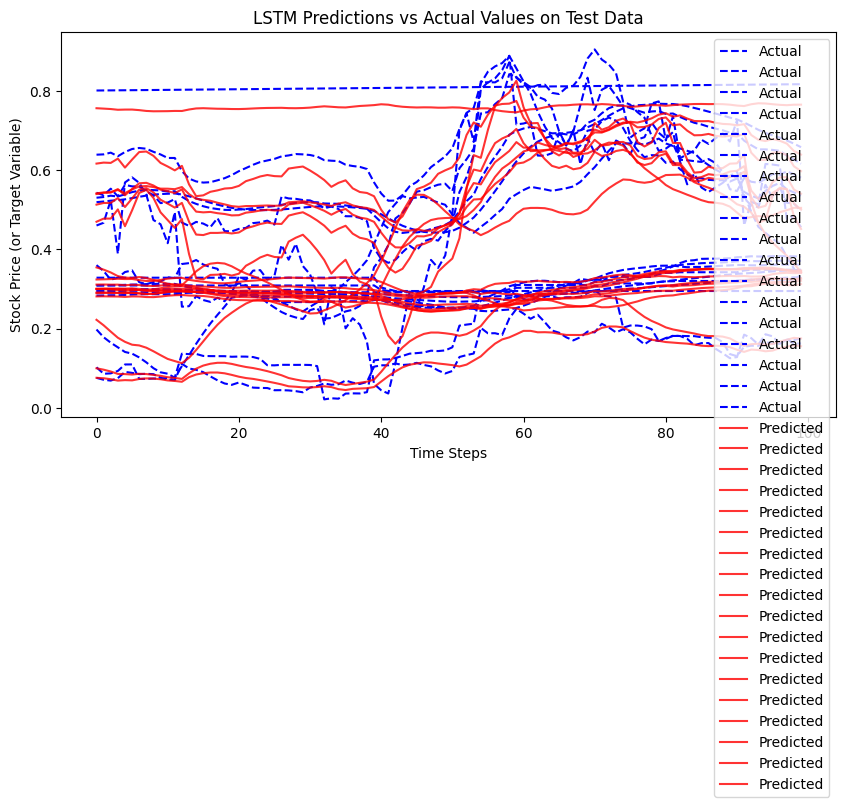

In [7]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure model is in evaluation mode (disables dropout & batch norm)
lstm_model.eval()

# Move X_test to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Disable gradient calculations for inference
with torch.no_grad():
    y_pred_tensor = lstm_model(X_test_tensor)

# Move predictions to CPU
y_pred_numpy = y_pred_tensor.cpu().numpy()

# ✅ Fix: y_test is already NumPy, so no .cpu() needed
y_test_numpy = y_test  # No need for .cpu().numpy()

# 🔹 Compute Evaluation Metrics
mse = mean_squared_error(y_test_numpy, y_pred_numpy)
mae = mean_absolute_error(y_test_numpy, y_pred_numpy)
r2 = r2_score(y_test_numpy, y_pred_numpy)

# Print metrics
print(f"🔹 Test MSE: {mse:.6f}")
print(f"🔹 Test MAE: {mae:.6f}")
print(f"🔹 R² Score: {r2:.4f}")

# 🔹 Plot Actual vs Predicted (First 100 Samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test_numpy[:100], label="Actual", linestyle="dashed", color="blue")
plt.plot(y_pred_numpy[:100], label="Predicted", alpha=0.8, color="red")
plt.legend()
plt.title("LSTM Predictions vs Actual Values on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (or Target Variable)")
plt.show()


### Hyper tuning

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define LSTM Model
def create_lstm_model(input_dim, hidden_dim, num_layers, dropout, output_dim):
    class LSTMModel(nn.Module):
        def __init__(self):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            return self.fc(lstm_out[:, -1, :])  # Take the last time step output
    
    return LSTMModel()

# Objective function for Optuna
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    
    lstm_model = create_lstm_model(input_dim=X_train.shape[2], hidden_dim=hidden_dim,
                              num_layers=num_layers, dropout=dropout, output_dim=y_train.shape[1])
    lstm_model.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    
    # DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    lstm_model.train()
    for epoch in range(10):  # Small epochs for tuning
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = lstm_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    return loss.item()

# Run Optuna study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Run 20 trials

# Best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2025-03-08 21:15:11,861] A new study created in memory with name: no-name-6c6fe4e7-c382-48c6-b388-13ec4f44b524
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5280\3038151413.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[W 2025-03-08 21:15:14,441] Trial 0 failed with parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.30000000000000004, 'batch_size': 64, 'learning_rate': 0.00045762520491143534} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "e:\Python\venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_5280\3038151413.py", line 45, in obje

KeyboardInterrupt: 

## Model with the parameters that came out of the previous testing

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Define Optimized LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim=192, num_layers=2, output_size=17, dropout_prob=0.5):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers=num_layers, dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take only the last timestep output
        return x

# Instantiate model with optimized hyperparameters
input_size = X_train.shape[2]  # Number of features
output_size = y_train.shape[1]  # Number of target variables
lstm_model = LSTMModel(input_size, output_size=output_size).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0005839081038527126)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
batch_size = 16  # Optimized batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with progress bar
epochs = 10  # Adjust epochs based on early stopping
for epoch in range(epochs):
    lstm_model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(lstm_model.state_dict(), "Best_LSTM_model.pth")
print("✅ Best model saved as 'Best_LSTM_model.pth'")


🔥 Using device: cuda


Epoch 1/10: 100%|██████████| 308/308 [00:05<00:00, 61.05batch/s, loss=0.0044]


✅ Epoch [1/10], Loss: 0.0140, Val Loss: 0.0045


Epoch 2/10: 100%|██████████| 308/308 [00:04<00:00, 65.44batch/s, loss=0.0028]


✅ Epoch [2/10], Loss: 0.0030, Val Loss: 0.0034


Epoch 3/10: 100%|██████████| 308/308 [00:04<00:00, 65.73batch/s, loss=0.0022]


✅ Epoch [3/10], Loss: 0.0021, Val Loss: 0.0020


Epoch 4/10: 100%|██████████| 308/308 [00:04<00:00, 65.56batch/s, loss=0.0013]


✅ Epoch [4/10], Loss: 0.0017, Val Loss: 0.0016


Epoch 5/10: 100%|██████████| 308/308 [00:04<00:00, 66.27batch/s, loss=0.0011]


✅ Epoch [5/10], Loss: 0.0015, Val Loss: 0.0014


Epoch 6/10: 100%|██████████| 308/308 [00:04<00:00, 66.45batch/s, loss=0.0009]


✅ Epoch [6/10], Loss: 0.0013, Val Loss: 0.0013


Epoch 7/10: 100%|██████████| 308/308 [00:04<00:00, 66.45batch/s, loss=0.0040]


✅ Epoch [7/10], Loss: 0.0012, Val Loss: 0.0010


Epoch 8/10: 100%|██████████| 308/308 [00:04<00:00, 66.89batch/s, loss=0.0020]


✅ Epoch [8/10], Loss: 0.0011, Val Loss: 0.0013


Epoch 9/10: 100%|██████████| 308/308 [00:04<00:00, 66.20batch/s, loss=0.0006]


✅ Epoch [9/10], Loss: 0.0011, Val Loss: 0.0010


Epoch 10/10: 100%|██████████| 308/308 [00:04<00:00, 66.01batch/s, loss=0.0007]


✅ Epoch [10/10], Loss: 0.0010, Val Loss: 0.0011
✅ Best model saved as 'Best_LSTM_model.pth'


🔹 Test MSE: 0.001070
🔹 Test MAE: 0.024562
🔹 R² Score: 0.8439


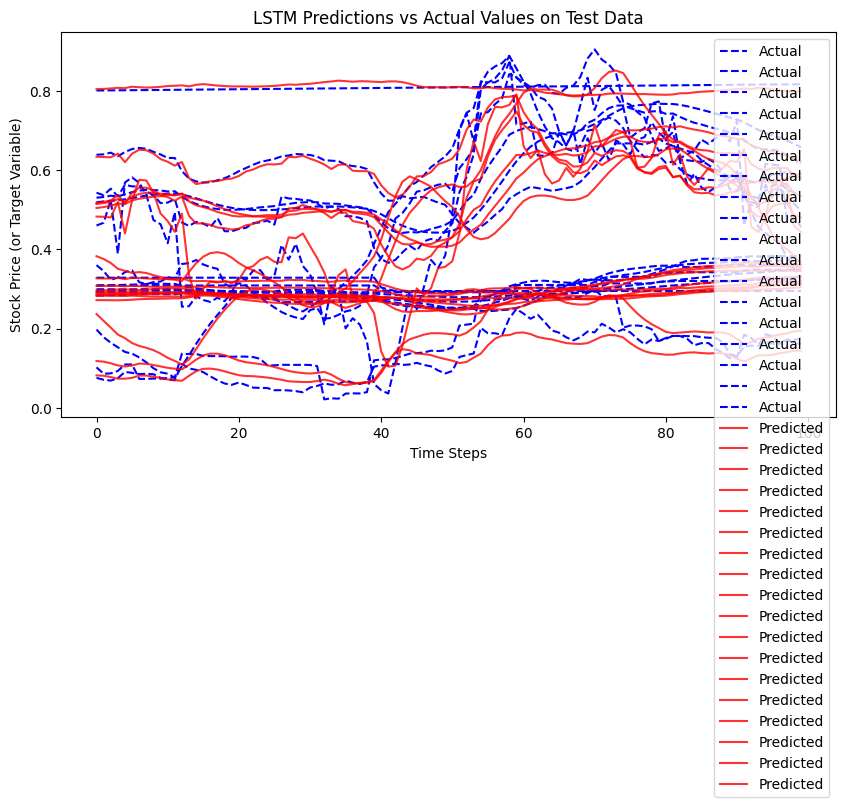

In [9]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure model is in evaluation mode (disables dropout & batch norm)
lstm_model.eval()

# Move X_test to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Disable gradient calculations for inference
with torch.no_grad():
    y_pred_tensor = lstm_model(X_test_tensor)

# Move predictions to CPU
y_pred_numpy = y_pred_tensor.cpu().numpy()

# ✅ Fix: y_test is already NumPy, so no .cpu() needed
y_test_numpy = y_test  # No need for .cpu().numpy()

# 🔹 Compute Evaluation Metrics
mse = mean_squared_error(y_test_numpy, y_pred_numpy)
mae = mean_absolute_error(y_test_numpy, y_pred_numpy)
r2 = r2_score(y_test_numpy, y_pred_numpy)

# Print metrics
print(f"🔹 Test MSE: {mse:.6f}")
print(f"🔹 Test MAE: {mae:.6f}")
print(f"🔹 R² Score: {r2:.4f}")

# 🔹 Plot Actual vs Predicted (First 100 Samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test_numpy[:100], label="Actual", linestyle="dashed", color="blue")
plt.plot(y_pred_numpy[:100], label="Predicted", alpha=0.8, color="red")
plt.legend()
plt.title("LSTM Predictions vs Actual Values on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (or Target Variable)")
plt.show()


# Feedforward Neural Network (FNN)
### Predict the close price from the indicator values

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Feature selection
features = [
    "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
    "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
    "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", "seconds"
]

X = df[features].to_numpy()
y_close = df["close"].to_numpy()

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_close, test_size=0.2, random_state=42, shuffle=False)

# Initialize scalers
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1).to(device)  # Fix shape
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1).to(device)  # Fix shape

In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # Progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")


# Neural Network Model
class PricePredictionNN(nn.Module):
    def __init__(self, input_size):
        super(PricePredictionNN, self).__init__()
        self.FNN_model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)  
        )

    def forward(self, x):
        return self.FNN_model(x)

# Instantiate FNN_model
input_size = len(features)
FNN_model = PricePredictionNN(input_size).to(device)

# Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(FNN_model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training Loop
epochs = 50
for epoch in range(epochs):
    FNN_model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        predictions = FNN_model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    scheduler.step()  # Reduce learning rate

    # Validation Loss
    FNN_model.eval()
    with torch.no_grad():
        val_predictions = FNN_model(X_test_tensor).squeeze()
        val_loss = criterion(val_predictions, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save FNN_model
torch.save(FNN_model.state_dict(), "FNN_price_from_Indicators.pth")
print("✅ Model saved as 'LARGE_FNN_price_model.pth'")

🔥 Using device: cuda


Epoch 1/50: 100%|██████████| 78/78 [00:00<00:00, 132.28batch/s, loss=0.0477]
e:\Python\venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1241, 1])) that is different to the input size (torch.Size([1241])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


✅ Epoch [1/50], Loss: 0.1696, Val Loss: 0.2477


Epoch 2/50: 100%|██████████| 78/78 [00:00<00:00, 166.78batch/s, loss=0.0362]


✅ Epoch [2/50], Loss: 0.0505, Val Loss: 0.2044


Epoch 3/50: 100%|██████████| 78/78 [00:00<00:00, 172.03batch/s, loss=0.0686]


✅ Epoch [3/50], Loss: 0.0437, Val Loss: 0.2346


Epoch 4/50: 100%|██████████| 78/78 [00:00<00:00, 161.44batch/s, loss=0.1478]


✅ Epoch [4/50], Loss: 0.0396, Val Loss: 0.2210


Epoch 5/50: 100%|██████████| 78/78 [00:00<00:00, 167.23batch/s, loss=0.0663]


✅ Epoch [5/50], Loss: 0.0346, Val Loss: 0.2212


Epoch 6/50: 100%|██████████| 78/78 [00:00<00:00, 165.96batch/s, loss=0.0192]


✅ Epoch [6/50], Loss: 0.0358, Val Loss: 0.2305


Epoch 7/50: 100%|██████████| 78/78 [00:00<00:00, 168.23batch/s, loss=0.0262]


✅ Epoch [7/50], Loss: 0.0326, Val Loss: 0.2101


Epoch 8/50: 100%|██████████| 78/78 [00:00<00:00, 150.65batch/s, loss=0.0458]


✅ Epoch [8/50], Loss: 0.0310, Val Loss: 0.2175


Epoch 9/50: 100%|██████████| 78/78 [00:00<00:00, 168.41batch/s, loss=0.0285]


✅ Epoch [9/50], Loss: 0.0294, Val Loss: 0.2195


Epoch 10/50: 100%|██████████| 78/78 [00:00<00:00, 166.29batch/s, loss=0.0438]


✅ Epoch [10/50], Loss: 0.0306, Val Loss: 0.2031


Epoch 11/50: 100%|██████████| 78/78 [00:00<00:00, 156.10batch/s, loss=0.0792]


✅ Epoch [11/50], Loss: 0.0254, Val Loss: 0.2118


Epoch 12/50: 100%|██████████| 78/78 [00:00<00:00, 172.33batch/s, loss=0.0786]


✅ Epoch [12/50], Loss: 0.0269, Val Loss: 0.2046


Epoch 13/50: 100%|██████████| 78/78 [00:00<00:00, 167.70batch/s, loss=0.0949]


✅ Epoch [13/50], Loss: 0.0296, Val Loss: 0.2042


Epoch 14/50: 100%|██████████| 78/78 [00:00<00:00, 165.03batch/s, loss=0.0319]


✅ Epoch [14/50], Loss: 0.0283, Val Loss: 0.2045


Epoch 15/50: 100%|██████████| 78/78 [00:00<00:00, 154.62batch/s, loss=0.0201]


✅ Epoch [15/50], Loss: 0.0274, Val Loss: 0.2067


Epoch 16/50: 100%|██████████| 78/78 [00:00<00:00, 166.92batch/s, loss=0.0573]


✅ Epoch [16/50], Loss: 0.0273, Val Loss: 0.2084


Epoch 17/50: 100%|██████████| 78/78 [00:00<00:00, 162.95batch/s, loss=0.0467]


✅ Epoch [17/50], Loss: 0.0300, Val Loss: 0.2070


Epoch 18/50: 100%|██████████| 78/78 [00:00<00:00, 145.86batch/s, loss=0.0354]


✅ Epoch [18/50], Loss: 0.0211, Val Loss: 0.2057


Epoch 19/50: 100%|██████████| 78/78 [00:00<00:00, 168.55batch/s, loss=0.0148]


✅ Epoch [19/50], Loss: 0.0268, Val Loss: 0.2002


Epoch 20/50: 100%|██████████| 78/78 [00:00<00:00, 167.80batch/s, loss=0.0155]


✅ Epoch [20/50], Loss: 0.0240, Val Loss: 0.2082


Epoch 21/50: 100%|██████████| 78/78 [00:00<00:00, 172.20batch/s, loss=0.0088]


✅ Epoch [21/50], Loss: 0.0219, Val Loss: 0.1991


Epoch 22/50: 100%|██████████| 78/78 [00:00<00:00, 157.21batch/s, loss=0.0266]


✅ Epoch [22/50], Loss: 0.0263, Val Loss: 0.2104


Epoch 23/50: 100%|██████████| 78/78 [00:00<00:00, 172.66batch/s, loss=0.0559]


✅ Epoch [23/50], Loss: 0.0256, Val Loss: 0.2028


Epoch 24/50: 100%|██████████| 78/78 [00:00<00:00, 172.36batch/s, loss=0.0334]


✅ Epoch [24/50], Loss: 0.0261, Val Loss: 0.2006


Epoch 25/50: 100%|██████████| 78/78 [00:00<00:00, 165.87batch/s, loss=0.0553]


✅ Epoch [25/50], Loss: 0.0300, Val Loss: 0.2112


Epoch 26/50: 100%|██████████| 78/78 [00:00<00:00, 151.64batch/s, loss=0.0272]


✅ Epoch [26/50], Loss: 0.0257, Val Loss: 0.2043


Epoch 27/50: 100%|██████████| 78/78 [00:00<00:00, 165.95batch/s, loss=0.0061]


✅ Epoch [27/50], Loss: 0.0259, Val Loss: 0.2082


Epoch 28/50: 100%|██████████| 78/78 [00:00<00:00, 163.84batch/s, loss=0.0323]


✅ Epoch [28/50], Loss: 0.0253, Val Loss: 0.2039


Epoch 29/50: 100%|██████████| 78/78 [00:00<00:00, 165.63batch/s, loss=0.0440]


✅ Epoch [29/50], Loss: 0.0239, Val Loss: 0.2105


Epoch 30/50: 100%|██████████| 78/78 [00:00<00:00, 149.33batch/s, loss=0.0242]


✅ Epoch [30/50], Loss: 0.0221, Val Loss: 0.2023


Epoch 31/50: 100%|██████████| 78/78 [00:00<00:00, 170.88batch/s, loss=0.0328]


✅ Epoch [31/50], Loss: 0.0230, Val Loss: 0.2055


Epoch 32/50: 100%|██████████| 78/78 [00:00<00:00, 166.53batch/s, loss=0.0226]


✅ Epoch [32/50], Loss: 0.0184, Val Loss: 0.2094


Epoch 33/50: 100%|██████████| 78/78 [00:00<00:00, 168.70batch/s, loss=0.0398]


✅ Epoch [33/50], Loss: 0.0270, Val Loss: 0.2051


Epoch 34/50: 100%|██████████| 78/78 [00:00<00:00, 150.32batch/s, loss=0.0478]


✅ Epoch [34/50], Loss: 0.0202, Val Loss: 0.2118


Epoch 35/50: 100%|██████████| 78/78 [00:00<00:00, 167.70batch/s, loss=0.0168]


✅ Epoch [35/50], Loss: 0.0207, Val Loss: 0.2061


Epoch 36/50: 100%|██████████| 78/78 [00:00<00:00, 157.69batch/s, loss=0.0285]


✅ Epoch [36/50], Loss: 0.0257, Val Loss: 0.2068


Epoch 37/50: 100%|██████████| 78/78 [00:00<00:00, 174.38batch/s, loss=0.0556]


✅ Epoch [37/50], Loss: 0.0244, Val Loss: 0.2074


Epoch 38/50: 100%|██████████| 78/78 [00:00<00:00, 151.22batch/s, loss=0.0135]


✅ Epoch [38/50], Loss: 0.0206, Val Loss: 0.2034


Epoch 39/50: 100%|██████████| 78/78 [00:00<00:00, 166.63batch/s, loss=0.0377]


✅ Epoch [39/50], Loss: 0.0227, Val Loss: 0.2084


Epoch 40/50: 100%|██████████| 78/78 [00:00<00:00, 168.15batch/s, loss=0.0190]


✅ Epoch [40/50], Loss: 0.0217, Val Loss: 0.2093


Epoch 41/50: 100%|██████████| 78/78 [00:00<00:00, 166.64batch/s, loss=0.0246]


✅ Epoch [41/50], Loss: 0.0208, Val Loss: 0.2074


Epoch 42/50: 100%|██████████| 78/78 [00:00<00:00, 156.60batch/s, loss=0.0401]


✅ Epoch [42/50], Loss: 0.0226, Val Loss: 0.2062


Epoch 43/50: 100%|██████████| 78/78 [00:00<00:00, 170.61batch/s, loss=0.0148]


✅ Epoch [43/50], Loss: 0.0241, Val Loss: 0.2074


Epoch 44/50: 100%|██████████| 78/78 [00:00<00:00, 156.84batch/s, loss=0.1210]


✅ Epoch [44/50], Loss: 0.0248, Val Loss: 0.2096


Epoch 45/50: 100%|██████████| 78/78 [00:00<00:00, 142.58batch/s, loss=0.0119]


✅ Epoch [45/50], Loss: 0.0204, Val Loss: 0.2105


Epoch 46/50: 100%|██████████| 78/78 [00:00<00:00, 165.92batch/s, loss=0.0098]


✅ Epoch [46/50], Loss: 0.0215, Val Loss: 0.2059


Epoch 47/50: 100%|██████████| 78/78 [00:00<00:00, 177.32batch/s, loss=0.0119]


✅ Epoch [47/50], Loss: 0.0251, Val Loss: 0.2109


Epoch 48/50: 100%|██████████| 78/78 [00:00<00:00, 173.55batch/s, loss=0.0273]


✅ Epoch [48/50], Loss: 0.0234, Val Loss: 0.2080


Epoch 49/50: 100%|██████████| 78/78 [00:00<00:00, 132.73batch/s, loss=0.1140]


✅ Epoch [49/50], Loss: 0.0227, Val Loss: 0.2043


Epoch 50/50: 100%|██████████| 78/78 [00:00<00:00, 157.56batch/s, loss=0.0144]

✅ Epoch [50/50], Loss: 0.0245, Val Loss: 0.2104
✅ Model saved as 'LARGE_FNN_price_model.pth'


In [66]:
import matplotlib.pyplot as plt

# Function to Predict Future Prices and Reverse Scaling
def predict_price(FNN_model, X_new, scaler_y):
    FNN_model.eval()
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
    with torch.no_grad():
        scaled_predictions = FNN_model(X_new_tensor).cpu().numpy()
    
    # Reverse scaling to get actual prices
    real_predictions = scaler_y.inverse_transform(scaled_predictions)
    
    return real_predictions

# Get predictions on test set
predicted_prices = predict_price(FNN_model, X_test_scaled, scaler_y).flatten()
actual_prices = y_test  # Already in original scale

# Print sample predictions vs. actual values
print("Sample Predictions (Real Scale):", predicted_prices[:10])
print("Sample Actual Prices:", actual_prices[:10])

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices", color="blue", alpha=0.7)
plt.plot(predicted_prices, label="Predicted Prices", color="red", linestyle="dashed", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.show()


NameError: name 'FNN_model' is not defined

## Testing of Complete Architecture

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load saved models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load LSTM Model
lstm_input_size = len(features)  # Number of input features
lstm_hidden_size = 192
lstm_num_layers = 2
lstm_output_size = len(features)  # Predicts all features

lstm_model = LSTMModel(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_output_size).to(device)
lstm_model.load_state_dict(torch.load("Best_LSTM_model.pth"))
lstm_model.eval()

# Load FNN Model
fnn_input_size = lstm_output_size  # Takes LSTM output as input
fnn_model = PricePredictionNN(fnn_input_size).to(device)
fnn_model.load_state_dict(torch.load("FNN_price_from_Indicators.pth"))
fnn_model.eval()

# Prepare data
X = df[features].values  # Extract input features
actual_prices = df["close"].values  # Extract actual prices

# Normalize input features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize target prices
scaler_y = MinMaxScaler()
actual_prices_scaled = scaler_y.fit_transform(actual_prices.reshape(-1, 1))

# Store results
predicted_prices = []

# Loop through the dataset
for i in range(len(df) - 1):  # Predict for each time step
    X_input = X_scaled[i]  # Take real normalized input at time t
    X_tensor = torch.tensor(X_input, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(0)  # Shape: (1,1,features)

    with torch.no_grad():
        lstm_output = lstm_model(X_tensor)  # Predict indicators
        predicted_price_scaled = fnn_model(lstm_output)  # Predict scaled future close price

        # Convert back to real price scale
        predicted_price_real = scaler_y.inverse_transform(predicted_price_scaled.cpu().numpy())
        predicted_prices.append(predicted_price_real.flatten()[0])

# Convert predictions to NumPy array for plotting
predicted_prices = np.array(predicted_prices)

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices[1:], label="Actual Prices", color="blue", alpha=0.7)
plt.plot(predicted_prices, label="Predicted Prices", color="red", linestyle="dashed", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.show()


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

# CPU Codes

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Enable GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ Using GPU:", gpus[0])
    tf.config.experimental.set_memory_growth(gpus[0], True)  # Prevents memory overload
else:
    print("⚠️ No GPU detected, using CPU.")

def build_lstm_model(input_shape, output_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(output_shape, activation="linear"),  # Linear for regression
    ])
    
    model.compile(loss="mse", optimizer="adam")  # No need to add mse as metric (loss is already mse)
    return model

# Build the model
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_shape=y_train.shape[1])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,  # Reduced epochs
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1  # Show cleaner progress
)

# Save the model
model_path = models_dir / "LSTM_FNN_LSTM_model.h5"
model.save(str(model_path))


⚠️ No GPU detected, using CPU.
Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0780 - val_loss: 0.0079
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0150 - val_loss: 0.0049
Epoch 3/50
 81/154 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0103

KeyboardInterrupt: 